# Air quality impact on hives survival 

The dataset is from Nectar 1.19 and cover hives from 2020 to 2023. The 2023 season is currently censored in terms of winter mortality but you can analyse the acute effect (which I didn't include in the blog post but I did have a look at the effect on the summer mortality and the effect are even stronger). I also shared the complete daily history for all the yards in the dataset for air quality , ndvi and weather that was scrapped from Airpyllution package, meteostats package and earth engine. Finally, you will find a file called 'ops_meta.csv' which contains the region of the given operations. 

The file are found on this google drive: [here](https://drive.google.com/drive/u/0/folders/1UZ3_jzMRdaQEaIR1TzPqEWTb0azECStB)


***
### SETUP

In [363]:
import os 
import ast
from datetime import datetime, date,timezone, timedelta

import pandas as pd 
import numpy as np
from collections import Counter

import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import skew, kurtosis
from pymer4.models import Lmer
from lifelines import KaplanMeierFitter, CoxPHFitter
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import RandomizedSearchCV

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

NECTAR_PALETTE = "blend:#D8A348,#1D1D1D"
sns.set_palette(NECTAR_PALETTE)

ROOT_PATH = "../data"
SEASONS_INCLUDED = [2021, 2022, 2023]
FEATURES_MONTH = [6,7,8]
RUN_PREPROCESS = True

START_SEASON_MONTH = 6
START_SEASON_DAY = 1
END_SEASON_MONTH = 10
END_SEASON_DAY = 1

In [364]:
from aqi.data.utils import timestamp_to_date, try_check_month
from aqi.vizualisation.utils import plot_survival_bar_per_state

***
### LOADING DATA

In [371]:
if RUN_PREPROCESS:
    operation_meta = pd.read_csv(os.path.join(ROOT_PATH,"ops_meta.csv"))
    aqi = pd.read_csv(os.path.join(ROOT_PATH,"aqi_dev.csv"))
    weather = pd.read_csv(os.path.join(ROOT_PATH,"weather_dev.csv"))
    ee = pd.read_csv(os.path.join(ROOT_PATH,"ee_dev.csv"))
    ee.drop("ee-image",axis=1,inplace=True)
    ee.dropna(subset=["ndvi"],inplace=True)
    
    mov = pd.read_csv(os.path.join(ROOT_PATH,"mouvements.csv"))

    data = pd.read_csv(os.path.join(ROOT_PATH,"merged_dev.csv"))
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))
data['death_date'] = pd.to_datetime(data['death_date'], format='mixed')
data = data.loc[data['season'].isin(SEASONS_INCLUDED)]

In [372]:
len(data)

148249

In [373]:
def norm_1_10(data):
    start = 1
    end = 10
    width = end - start
    return (data - data.min())/data.ptp() * width + start
    

In [374]:
if RUN_PREPROCESS:
    weather.isnull().mean() # For some reason atmost pressure is not getting scrapped 

In [375]:
if RUN_PREPROCESS:
    aqi['aqhi'] = norm_1_10(aqi['aqhi'].values)
    aqi.isnull().mean()

In [376]:
if RUN_PREPROCESS:
    ee.isnull().mean() # 2023 is null , need to update for simulations later...

In [377]:
if RUN_PREPROCESS:
    ee.head()

In [378]:
if RUN_PREPROCESS:
    data['creation_date'] = pd.to_datetime(data['creation_date'],format='mixed').dt.date
    data['death_date']= pd.to_datetime(data['death_date']).dt.date

In [379]:
if RUN_PREPROCESS:
    Counter(data.hid.value_counts()) # Meaning that 16 632 hives are present in two season while 38405 are only in one season 

In [380]:
if RUN_PREPROCESS:
    ### Label creation (based on season start end)
    
    def get_state_for_season(state_log):
        return state_log.apply(lambda x : x['death_date'] != date(x['season']+1,START_SEASON_MONTH,START_SEASON_DAY), axis=1)
    
    def get_age_for_season(state_log):
        return state_log.apply(lambda x : abs((x['death_date'] - x['creation_date']).days), axis=1)
    
    
    data['death_next_season'] = get_state_for_season(data)
    data['hive_age_next_season'] = get_age_for_season(data)

In [381]:
data['death_next_season'].mean()

0.21521898967278025

In [382]:
data.dtypes

hid                      int64
creation_date           object
operation_id             int64
death_date              object
season                   int64
death_next_season         bool
hive_age_next_season     int64
dtype: object

In [383]:
data.operation_id.value_counts()

operation_id
193    44996
69     33202
153    18265
55     14186
167    10597
161     8221
87      5841
207     5607
210     1720
195     1588
36      1084
194      789
212      741
219      397
160      322
159      228
205      193
83       188
220       82
199        2
Name: count, dtype: int64

In [384]:
data.season.value_counts()

season
2023    107172
2022     32164
2021      8913
Name: count, dtype: int64

In [385]:
data.drop(['death_date','creation_date'],axis=1).groupby(['season','operation_id']).mean(numeric_only=True)[['death_next_season','hive_age_next_season']]

death_next_season  hive_age_next_season
season operation_id                                         
2021   36                     0.034884            374.296512
       55                     0.631184            319.231549
       69                     0.653664            345.589835
       83                     0.000000            308.000000
       87                     0.868106            233.582734
2022   36                     0.307978            509.821892
       55                     0.238085            551.987305
       69                     0.338473            357.186206
       83                     0.552632            393.394737
       87                     0.566813            404.662103
       153                    0.408203            381.321779
       159                    0.706897            292.086207
       160                    0.275862            343.672414
       161                    0.326817            263.603543
       167                    0.950954            343.819255
2023   36                     0.000000            913.525469
       55                     0.049328            734.802267
       69                     0.138861            509.819924
       83                     0.055556            822.444444
       87                     0.171852            448.547395
       153                    0.045369            573.771176
       159                    0.035714            461.142857
       160                    0.063107            558.873786
       161                    0.029715            501.978775
       167                    0.137848            337.949031
       193                    0.154325            421.237221
       194                    0.048162            318.356147
       195                    0.034005            315.068010
       199                    0.000000            423.500000
       205                    0.000000            356.248705
       207                    0.227751            271.232388
       210                    0.070349            313.478488
       212                    0.331984            225.112011
       219                    0.007557            251.350126
       220                    0.000000            256.000000

In [386]:
if RUN_PREPROCESS:
    # BAD OPS
    data = data.loc[~data['operation_id'].isin([51,167,84])]

In [387]:
len(data)

137652

In [388]:
data.isnull().mean()

hid                     0.0
creation_date           0.0
operation_id            0.0
death_date              0.0
season                  0.0
death_next_season       0.0
hive_age_next_season    0.0
dtype: float64

### Feature eng for predictive models


### From mouvements to sensors data 

- Idea is to get the location of the hive at time X between june 1st and August 31 
- Once we have that info we simply do statistic on the sequence 


***
### One hive example

In [389]:
if RUN_PREPROCESS:
    mov['to_when'].fillna(date.today(),inplace=True) # When null still didn't moved
    mov['from_when'] = pd.to_datetime(mov['from_when'],format='mixed').dt.date
    mov['to_when'] = pd.to_datetime(mov['to_when'],format='mixed').dt.date
    
    aqi['time'] = pd.to_datetime(aqi['time'],format='mixed').dt.date
    weather['time'] = pd.to_datetime(weather['time'],format='mixed').dt.date
    ee['time'] = pd.to_datetime(ee['time'],format='mixed').dt.date

In [390]:
if RUN_PREPROCESS:
    # Only keep aqi, weather and ee for summer month 
    
    aqi = aqi.loc[pd.to_datetime(aqi['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    weather = weather.loc[pd.to_datetime(weather['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)
    ee = ee.loc[pd.to_datetime(ee['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [391]:
if RUN_PREPROCESS:
    one = mov.loc[mov['hive_identity_id']==21199]

In [392]:
if RUN_PREPROCESS:
    one = (one.assign(time = [pd.date_range(start, end) 
                       for start, end 
                       in zip(one['from_when'], one['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [393]:
if RUN_PREPROCESS:
    one['time'] = pd.to_datetime(one['time']).dt.date

In [394]:
if RUN_PREPROCESS:
    one.head()

In [395]:
if RUN_PREPROCESS:
    one = pd.merge(one,aqi, on=["yard_id","time"])

In [396]:
if RUN_PREPROCESS:
    one['season'] = pd.to_datetime(one['time']).dt.year
    one['month'] = pd.to_datetime(one['time']).dt.month

In [423]:
if RUN_PREPROCESS:
    one[['season','month','aqhi']].groupby(["season","month"]).mean()

### ALL hives and sensors

In [425]:
if RUN_PREPROCESS:
    mov = mov[mov['hive_identity_id'].isin(list(data.hid.unique()))].reset_index(drop=True)

In [426]:
if RUN_PREPROCESS:
    # WARNING THIS TAKES A WHILE (5 minutes...or so)
    mov = (mov.assign(time = [pd.date_range(start,end) 
                       for start, end 
                       in zip(mov['from_when'], mov['to_when'])]
              )
       .explode('time', ignore_index = True)
    )

In [427]:
if RUN_PREPROCESS:
    mov['time'] = pd.to_datetime(mov['time']).dt.date
    
    mov = mov.loc[pd.to_datetime(mov['time']).dt.month.isin(FEATURES_MONTH)].reset_index(drop=True)

In [428]:
if RUN_PREPROCESS:
    merged = pd.merge(mov,aqi, on=["yard_id","time"])
    merged = pd.merge(merged,weather, on=["yard_id","time"])
    merged = pd.merge(merged,ee, on=["yard_id","time"])
    
    merged.head()

In [429]:
if RUN_PREPROCESS:
    merged.isnull().mean()

### TSun and Wdir high null, just ignore them 

In [430]:
if RUN_PREPROCESS:
    merged.drop(['tsun','wdir'],axis=1,inplace=True)

### Compute stats for each hid

In [431]:
if RUN_PREPROCESS:
    merged['season'] = pd.to_datetime(merged['time']).dt.year

In [432]:
if RUN_PREPROCESS:
    # THis takes 10 min or so locally
    averages = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).mean().reset_index()
    skewed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).agg(lambda x : skew(x)).reset_index()
    maxed = merged.drop(['from_when','to_when','time','submitted_at'],axis=1).groupby(["hive_identity_id","season"]).max().reset_index()

In [433]:
if RUN_PREPROCESS:
    averages.rename(columns={"aqhi":"aqhi_average","prcp":"prcp_average","wspd":"wspd_average","ndvi":"ndvi_average","tavg":"tavg_average","hive_identity_id":"hid"},inplace=True)
    skewed.rename(columns={"aqhi":"aqhi_skew","prcp":"prcp_skew","wspd":"wspd_skew","ndvi":"ndvi_skew","tavg":"tavg_skew","hive_identity_id":"hid"},inplace=True)
    maxed.rename(columns={"aqhi":"aqhi_max","prcp":"prcp_max","wspd":"wspd_max","ndvi":"ndvi_max","tavg":"tavg_max","hive_identity_id":"hid"},inplace=True)


### Bring remote sensors with season state (merge)

In [434]:
if RUN_PREPROCESS:
    print(len(data))
    data = pd.merge(data, averages[['season','hid','aqhi_average','prcp_average','wspd_average','ndvi_average','tavg_average']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, skewed[['season','hid','aqhi_skew','prcp_skew','wspd_skew','ndvi_skew','tavg_skew']], on=["season","hid"], how="left")
    print(len(data))
    data = pd.merge(data, maxed[['season','hid','aqhi_max','prcp_max','wspd_max','ndvi_max','tavg_max']], on=["season","hid"], how="left")
    print(len(data))

137652
137652
137652
137652


In [435]:
data.head()

,hid,creation_date,operation_id,death_date,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,...,aqhi_skew,prcp_skew,wspd_skew,ndvi_skew,tavg_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max
0,21199,2021-06-23,55,2022-06-01,2021,False,343,1.164223,0.1,5.20,...,-4.653820e-14,0.0,3.252607e-15,0.000000e+00,0.0,1.171389,0.2,5.6,0.643625,20.4
1,38198,2021-09-27,55,2022-06-01,2021,False,247,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22571,2021-07-28,83,2022-06-01,2021,False,308,1.171389,0.0,4.80,...,NaN,NaN,NaN,NaN,NaN,1.171389,0.0,4.8,0.336577,16.4
3,19339,2021-06-18,69,2022-06-01,2021,False,348,1.207219,0.0,11.95,...,0.000000e+00,NaN,2.408966e-15,4.442735e-16,0.0,1.228717,0.0,13.1,0.501838,25.5
4,19340,2021-06-18,69,2022-06-01,2021,False,348,1.207219,0.0,11.95,...,0.000000e+00,NaN,2.408966e-15,4.442735e-16,0.0,1.228717,0.0,13.1,0.501838,25.5


In [436]:
len(data)

137652

### Add region

In [437]:
if RUN_PREPROCESS:
    operation_meta.index = operation_meta['Operation ID']
    regions = operation_meta.to_dict(orient="dict")['Location']

In [438]:
def try_region(x):
    try:
        return regions[str(x)].split(",")[1]
    except:
        return 'Unknown'

In [439]:
if RUN_PREPROCESS:
    data['region'] = data['operation_id'].apply(lambda x: try_region(x))
data['region'].value_counts()

region
 AB        57501
 CA        46584
 QC        24127
 FL         5607
 WA         1084
Unknown      895
 WY          789
 NY          741
 NS          322
 KS            2
Name: count, dtype: int64

### Saving preprocess so we don't need to run every time

In [440]:
if RUN_PREPROCESS:
    data.to_csv(os.path.join(ROOT_PATH,"preprocess.csv"),index=False)
else:
    data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [441]:
len(data)

137652

In [442]:
ONLY_WINTER = False
ONLY_INSEASON = False 
ACTIVE_ALL_AND_WINTER =True  # Blog post hypothesis 
if ONLY_WINTER or ONLY_INSEASON:
    assert ONLY_WINTER != ONLY_INSEASON, "choose one! or both False"
if ONLY_INSEASON or ACTIVE_ALL_AND_WINTER:
    assert ACTIVE_ALL_AND_WINTER != ONLY_INSEASON, "choose one! or both False"

# Reload and apply
data = pd.read_csv(os.path.join(ROOT_PATH,"preprocess.csv"))

In [443]:
len(data)

137652

In [444]:
if ONLY_WINTER:
    # Exclude in-season deadout , we are just looking at winter morta 
    data['winter_deadout'] = data.apply(lambda x: x['death_date'] > date(int(x['season']),END_SEASON_MONTH,END_SEASON_DAY),axis=1)
    data = data.loc[data['winter_deadout']].reset_index(drop=True)

if ONLY_INSEASON:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['winter_deadout'] = data.apply(lambda x: x['death_date'].month in [6,7,8],axis=1)
    data = data.loc[~data['winter_deadout'] | ~data['death_next_season']].reset_index(drop=True)

if ACTIVE_ALL_AND_WINTER:
    data['death_date'] = pd.to_datetime(data['death_date']).dt.date
    data['creation_date'] = pd.to_datetime(data['creation_date']).dt.date
    # This ensure the exposition rate is the full season (makes them comparable with the current approach)
    data = data.loc[(data['creation_date'] <= data['season'].apply(lambda x: date(int(x),START_SEASON_MONTH+1,START_SEASON_DAY))) \
            & (data['death_date'] > data['season'].apply(lambda x : date(int(x),END_SEASON_MONTH,END_SEASON_DAY)))]
    data = data.reset_index(drop=True)


### Keep next year aside and exclude some abnormal data

In [445]:
next_year = data.loc[data['season']==2023].reset_index(drop=True)
if not ONLY_INSEASON:
    data = data.loc[data['season']!=2023].reset_index(drop=True)

In [446]:
len(data)

30439

In [447]:
data.groupby(["death_next_season","season"]).mean(numeric_only=True)

hid  operation_id  hive_age_next_season  \
death_next_season season                                                     
False             2021    17142.420027     59.155415            367.472587   
                  2022    53375.674205     97.692630            445.451785   
True              2021    17087.594645     61.198126            343.560107   
                  2022    52545.046219    108.259505            401.855548   

                          aqhi_average  prcp_average  wspd_average  \
death_next_season season                                             
False             2021        1.180747      0.380909     11.049879   
                  2022        1.179916      1.038794     10.807450   
True              2021        1.180164      0.361834     11.488884   
                  2022        1.179279      0.766829     10.386509   

                          ndvi_average  tavg_average  aqhi_skew  prcp_skew  \
death_next_season season                                                     
False             2021        0.424834     19.871530   0.305737   0.427582   
                  2022        0.452435     17.207498  -0.207892   0.446374   
True              2021        0.459772     19.610112   0.287956   0.488198   
                  2022        0.398924     16.992298  -0.246668   0.513989   

                          wspd_skew  ndvi_skew  tavg_skew  aqhi_max  prcp_max  \
death_next_season season                                                        
False             2021     0.198110   0.097643   0.015265  1.202194  0.882102   
                  2022     0.052575  -0.339672  -0.122884  1.191725  2.494184   
True              2021     0.143533   0.068253   0.027405  1.199406  0.888434   
                  2022     0.108917  -0.340827  -0.081071  1.190111  1.852193   

                           wspd_max  ndvi_max   tavg_max  
death_next_season season                                  
False             2021    13.823108  0.512187  21.364341  
                  2022    13.428847  0.571514  20.980325  
True              2021    14.527175  0.541029  21.165114  
                  2022    13.680837  0.538159  21.125238

In [448]:
data.season.value_counts()

season
2022    24497
2021     5942
Name: count, dtype: int64

In [449]:
data.isnull().mean()

hid                     0.000000
creation_date           0.000000
operation_id            0.000000
death_date              0.000000
season                  0.000000
death_next_season       0.000000
hive_age_next_season    0.000000
aqhi_average            0.005618
prcp_average            0.005618
wspd_average            0.005618
ndvi_average            0.005618
tavg_average            0.005618
aqhi_skew               0.071060
prcp_skew               0.376294
wspd_skew               0.015901
ndvi_skew               0.007260
tavg_skew               0.015572
aqhi_max                0.005618
prcp_max                0.005618
wspd_max                0.005618
ndvi_max                0.005618
tavg_max                0.005618
region                  0.000000
dtype: float64

*** 
### Quick viz 

Just checking a bit the data for intuition

### Check different sensors bar chart

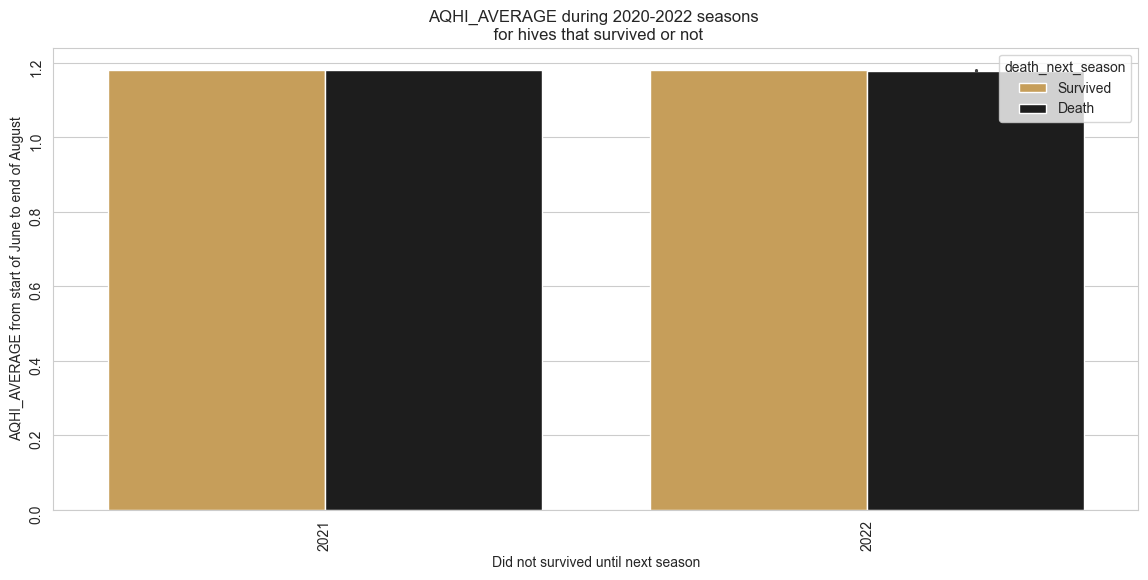

In [450]:
plot_survival_bar_per_state(data, "aqhi_average") # Bias by region for sure

### Check relation NDVI ~ AQHI


Idea is that increased vegetation should lead to less extreme AQHI value

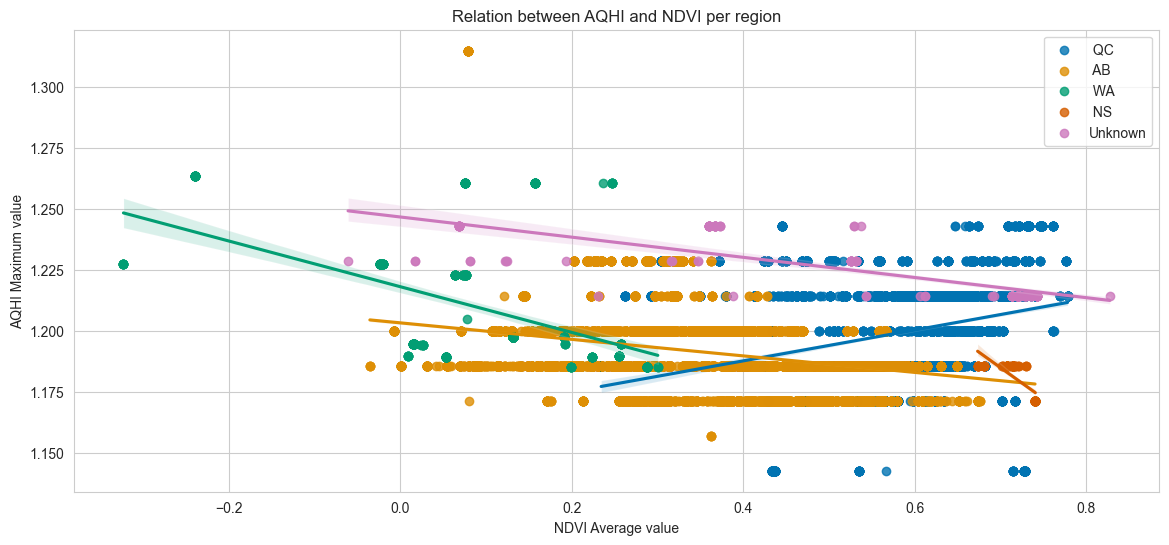

In [451]:
sns.set_palette('colorblind') # Otherwise very confusing 
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
for s in data['region'].unique():
    sub = data.loc[data['region']==s]
    if len(sub) > 10:
        sns.regplot(x=sub["ndvi_average"], y=sub["aqhi_max"], label=s, ax=ax)
plt.ylabel("AQHI Maximum value")
plt.xlabel("NDVI Average value")
plt.title("Relation between AQHI and NDVI per region")
plt.legend()
plt.show()

### Check raw AQHI ~ mortality

Pattern for Quebec are different from the rest of the dataset

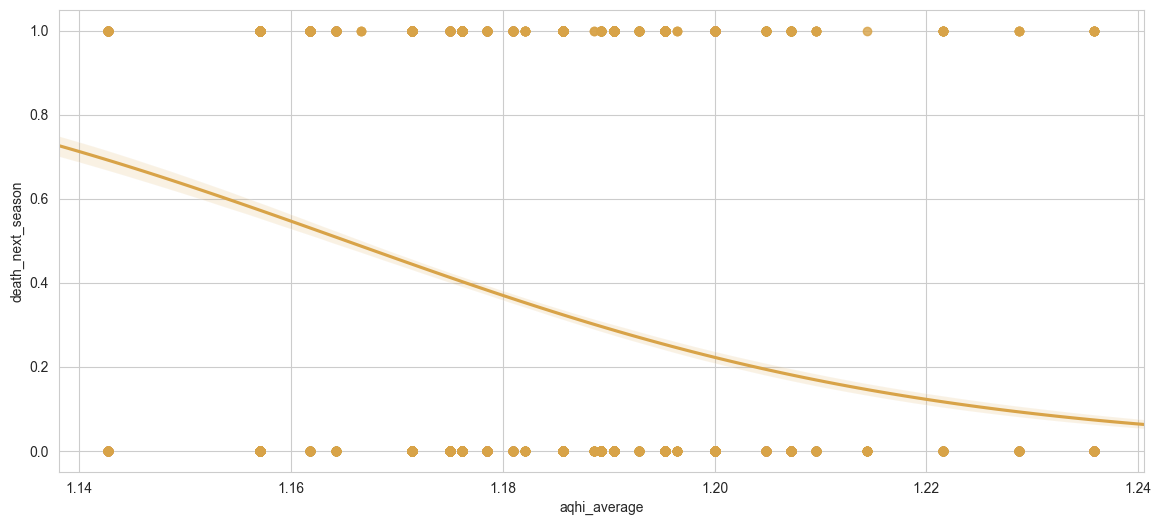

In [452]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']==" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

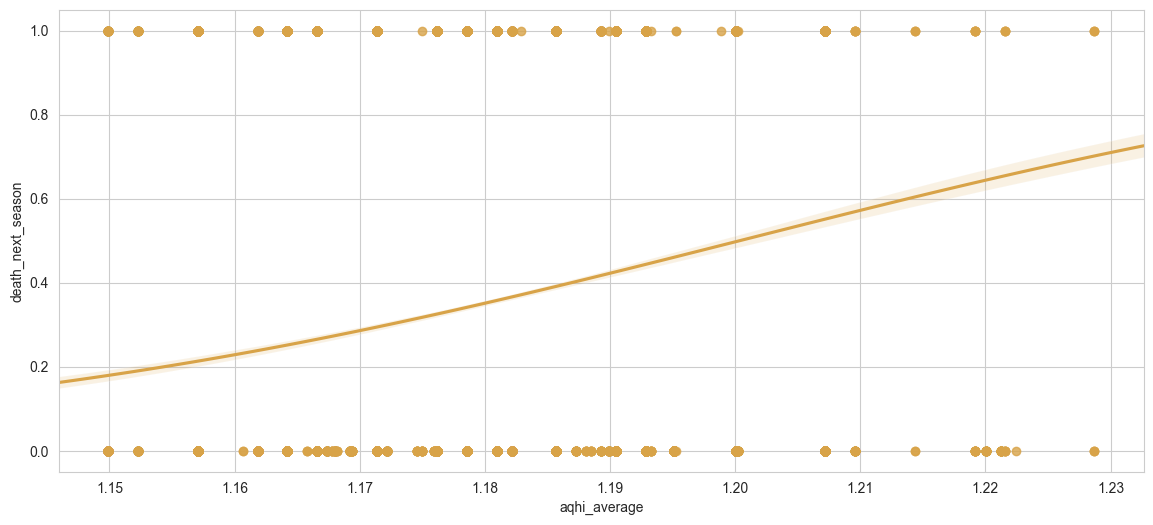

In [453]:
sns.set_palette(NECTAR_PALETTE)
sns.set_style("whitegrid")
_, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
sns.regplot(x="aqhi_average",y="death_next_season",data=data.loc[data['region']!=" QC"],logistic=True, truncate=False, ax=ax)
plt.show()

*** 
### Check per region

<Axes: xlabel='aqhi', ylabel='Density'>

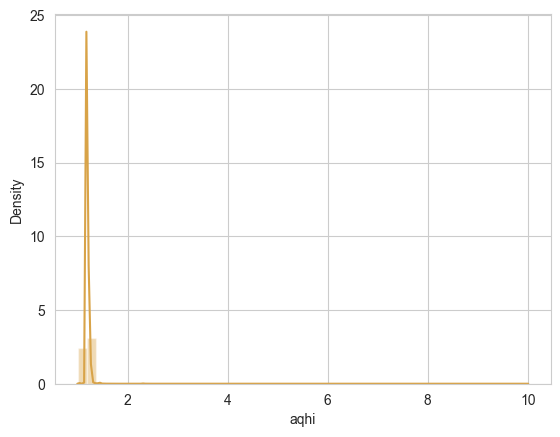

In [454]:
sns.distplot(aqi['aqhi'])

In [455]:
data.region.value_counts()

region
 AB        21661
 QC         8021
 WA          519
Unknown      146
 NS           92
Name: count, dtype: int64

In [456]:
data.groupby("region").mean(numeric_only=True)

,hid,operation_id,season,death_next_season,hive_age_next_season,aqhi_average,prcp_average,wspd_average,ndvi_average,tavg_average,aqhi_skew,prcp_skew,wspd_skew,ndvi_skew,tavg_skew,aqhi_max,prcp_max,wspd_max,ndvi_max,tavg_max
region,,,,,,,,,,,,,,,,,,,,
AB,52117.902590,100.687180,2021.882831,0.356909,394.927612,1.179109,0.772855,11.128865,0.390084,17.393223,-0.261076,0.481740,0.085542,-0.352426,-0.049906,1.190078,1.856207,14.341998,0.532196,21.145575
NS,57235.956522,160.000000,2022.000000,0.228261,379.467391,1.173855,5.177536,10.913225,0.717846,14.235145,0.560809,0.671719,0.611229,0.211670,-0.256701,1.180424,14.518478,16.040217,0.733306,18.540217
QC,30581.489964,73.963970,2021.596684,0.371525,472.692806,1.181101,1.010589,10.040174,0.588826,17.912207,0.268688,0.447677,0.093037,-0.048469,-0.177112,1.199653,2.418007,11.869741,0.636046,20.459211
WA,29417.398844,36.000000,2021.674374,0.007707,504.603083,1.187158,0.327778,9.770713,0.091410,24.016185,0.104507,-0.138800,0.015437,0.291424,-0.091928,1.209503,0.545472,12.650867,0.257972,26.821773
Unknown,58694.027397,132.972603,2022.000000,0.506849,378.095890,1.201544,1.389243,9.530201,0.531999,20.505437,0.125424,0.566515,-0.115486,0.080857,-0.351350,1.224652,3.818440,10.824823,0.586602,23.363121


In [457]:
data = data.loc[data['region']!=' CA']
data.region.value_counts()

region
 AB        21661
 QC         8021
 WA          519
Unknown      146
 NS           92
Name: count, dtype: int64

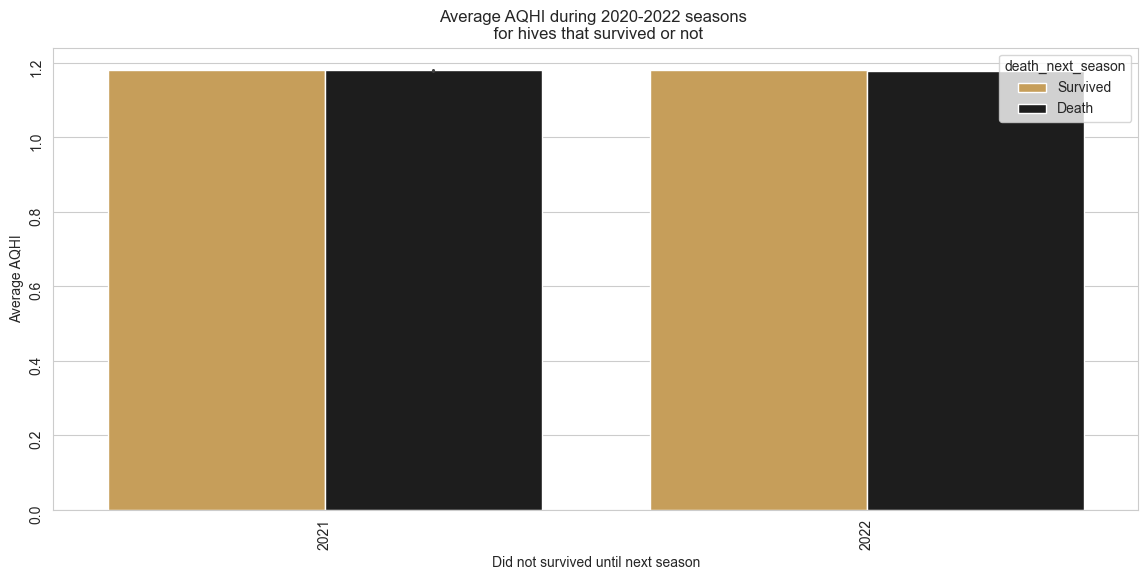

In [458]:
sns.set_style("whitegrid")
_, axes = plt.subplots(nrows=1, ncols=1, figsize=(14,6))
ax = sns.barplot(
    y=data['aqhi_average'],x=data['season'].astype(str),
    hue=data["death_next_season"].apply(lambda x : "Death" if x == 1 else "Survived"), ax=axes,
    palette="blend:#D8A348,#1D1D1D"#, errcolor="darkred"
)
#  
ax.set_ylabel("Average AQHI")
ax.set_xlabel("Did not survived until next season")
ax.tick_params(labelrotation=90)
plt.title("Average AQHI during 2020-2022 seasons \n for hives that survived or not")
plt.show()

***
### DESCRIPTIVE STATS

In [459]:
data[['aqhi_average','ndvi_average']].isnull().mean()

aqhi_average    0.005618
ndvi_average    0.005618
dtype: float64

In [460]:
data.fillna(0,inplace=True) # Filling null value with zero

data['operation_id'] = data['operation_id'].astype(str)
data['season'] = data['season'].astype(str)

### Models 

<Axes: xlabel='aqhi_average', ylabel='Count'>

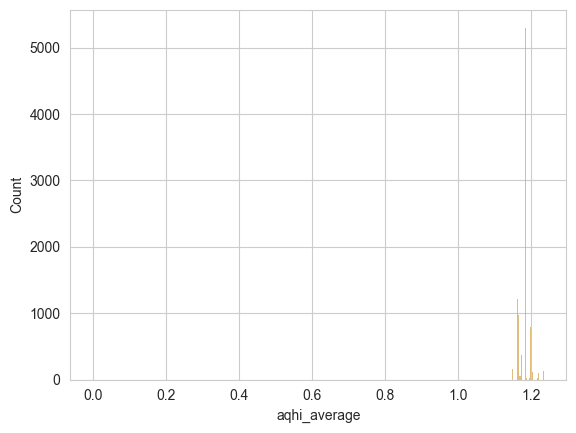

In [461]:
sns.histplot(data['aqhi_average'])

<Axes: xlabel='ndvi_average', ylabel='Count'>

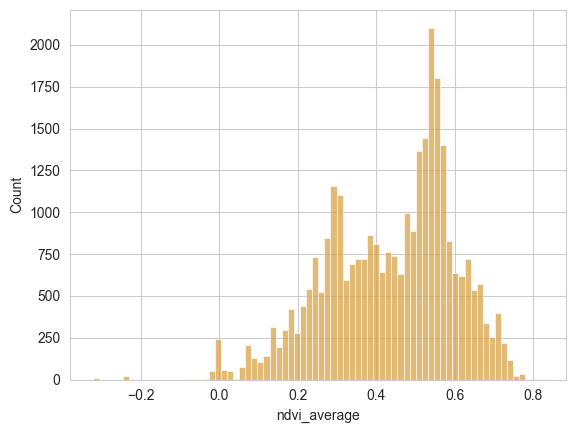

In [462]:
sns.histplot(data['ndvi_average'])

In [463]:
data.death_next_season.mean()

0.35513650251322315

In [464]:
model0 = Lmer("death_next_season  ~ 1 + (1|region)",
             data=data, family = 'binomial')

print(model0.fit())

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~1+(1|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -19597.962 	 AIC: 39199.924

Random effects:

               Name    Var    Std
region  (Intercept)  2.918  1.708

No random effect correlations specified

Fixed effects:

             Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)    -1.407  -2.833    0.018  0.727  0.245      0.059       1.018   

              Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val Sig  
(Intercept)  0.197        0.056         0.504  -1.935  0.053   .  


In [465]:
model = Lmer("death_next_season  ~  aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -19113.827 	 AIC: 38241.654

Random effects:

                Name     Var    Std
region   (Intercept)  93.483  9.669
region  aqhi_average  38.131  6.175

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE            OR  \
(Intercept)                  -6.013 -10.884   -1.143  2.485  2.000000e-03   
aqhi_average                  4.957   1.798    8.116  1.612  1.422010e+02   
ndvi_average                 28.567  25.050   32.084  1.794  2.549302e+12   
aqhi_average:ndvi_average   -26.577 -29.580  -23.573  1.532  0.000000e+00   

                              OR_2.5_ci    OR_97.5_ci   Prob  Pro

In [467]:
model2 = Lmer("death_next_season  ~ aqhi_average + ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model2.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -19209.917 	 AIC: 38431.834

Random effects:

                Name     Var    Std
region   (Intercept)  95.201  9.757
region  aqhi_average  40.117  6.334

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -5.591  -9.951   -1.231  2.224   0.004      0.000       0.292   
aqhi_average     4.494   1.640    7.348  1.456  89.478      5.153    1553.777   
ndvi_average    -2.552  -2.744   -2.359  0.098   0.078      0.064       0.094   

               Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  P-val  Sig  
(Intercept)   0.004        0.000         0.226  -2.513  0

In [468]:
model3 = Lmer("death_next_season  ~ aqhi_average*ndvi_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model3.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*ndvi_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -19113.827 	 AIC: 38241.654

Random effects:

                Name     Var    Std
region   (Intercept)  93.483  9.669
region  aqhi_average  38.131  6.175

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE            OR  \
(Intercept)                  -6.013 -10.884   -1.143  2.485  2.000000e-03   
aqhi_average                  4.957   1.798    8.116  1.612  1.422010e+02   
ndvi_average                 28.567  25.050   32.084  1.794  2.549302e+12   
aqhi_average:ndvi_average   -26.577 -29.580  -23.573  1.532  0.000000e+00   

                              OR_2.5_ci    OR_97.5_ci   Prob  Pro

In [469]:
model4 = Lmer("death_next_season  ~ aqhi_average + ndvi_average + tavg_average + prcp_average + wspd_average  + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model4.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average+ndvi_average+tavg_average+prcp_average+wspd_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -19053.843 	 AIC: 38125.687

Random effects:

                Name      Var     Std
region   (Intercept)  139.749  11.822
region  aqhi_average   66.154   8.134

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

              Estimate  2.5_ci  97.5_ci     SE      OR  OR_2.5_ci  OR_97.5_ci  \
(Intercept)     -5.907 -10.606   -1.208  2.397   0.003      0.000       0.299   
aqhi_average     3.998   0.796    7.199  1.634  54.464      2.216    1338.616   
ndvi_average    -1.330  -1.562   -1.098  0.118   0.265      0.210       0.334   
tavg_average     0.037   0.026    0.048  0.006   1.038      1.026       1.050   
p

In [470]:
model5 = Lmer("death_next_season  ~ aqhi_average*wspd_average + ndvi_average + tavg_average + prcp_average   + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model5.fit())

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average+ndvi_average+tavg_average+prcp_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -18892.926 	 AIC: 37805.852

Random effects:

                Name      Var     Std
region   (Intercept)  189.119  13.752
region  aqhi_average   91.964   9.590

                IV1           IV2  Corr
region  (Intercept)  aqhi_average  -1.0

Fixed effects:

                           Estimate  2.5_ci  97.5_ci     SE      OR  \
(Intercept)                  -6.916 -13.139   -0.693  3.175   0.001   
aqhi_average                  3.381  -1.009    7.771  2.240  29.394   
wspd_average                  2.681   2.384    2.979  0.152  14.605   
ndvi_average                 -1.229  -1.467   -0.991  0.121   0.293   
tavg_average                  0.139   0.123    0.15

In [471]:
model6 = Lmer("death_next_season  ~ aqhi_average*wspd_average*tavg_average + (aqhi_average|region)",
             data=data, family = 'binomial')

print(model6.fit())

[1] "Model failed to converge with max|grad| = 0.103279 (tol = 0.002, component 1)"
[2] " \n"                                                                          

[1] "Model is nearly unidentifiable: very large eigenvalue\n - Rescale variables?"
[2] " \n"                                                                         

[1] "Model is nearly unidentifiable: large eigenvalue ratio\n - Rescale variables?"
[2] " \n"                                                                          

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: death_next_season~aqhi_average*wspd_average*tavg_average+(aqhi_average|region)

Family: binomial	 Inference: parametric

Number of observations: 30439	 Groups: {'region': 5.0}

Log-likelihood: -18850.818 	 AIC: 37723.637

Random effects:

                Name     Var    Std
region   (Intercept)  62.727  7.920
region  aqhi_average  25.536  5.053

                IV1           IV2   Corr
region  (Intercept)  aqhi_average -0.99

In [ ]:
model7a = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average  + (aqhi_average|region) + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model7a.fit())

In [ ]:
model7 = Lmer("death_next_season  ~ aqhi_average*ndvi_average + wspd_average  + (aqhi_average|region) + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model7.fit())

In [ ]:
model8 = Lmer("death_next_season  ~ aqhi_average*ndvi_average*wspd_average  + (aqhi_average|region) ",
             data=data, family = 'binomial')

print(model8.fit())

In [ ]:
model9 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average*wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')
print(model9.fit())

In [ ]:
model10 = Lmer("death_next_season  ~ aqhi_skew*ndvi_skew  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model10.fit())

In [ ]:
model11 = Lmer("death_next_season  ~ aqhi_skew*ndvi_average + wspd_average  + (aqhi_skew|region) ",
             data=data, family = 'binomial')

print(model11.fit())

In [ ]:
model12 = Lmer("death_next_season  ~ aqhi_max*ndvi_average + wspd_average  + (aqhi_max|region) + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model12.fit())

In [ ]:
model13 = Lmer("death_next_season  ~ aqhi_average*log(wspd_average) + ndvi_average  + (aqhi_average|region) + (ndvi_average|region)",
             data=data, family = 'binomial')

print(model13.fit())

In [ ]:
model14 = Lmer("death_next_season  ~ aqhi_max*ndvi_average*wspd_average  + (aqhi_max|region) + (ndvi_average|region) ",
             data=data, family = 'binomial')

print(model14.fit())

In [ ]:
model15 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|region) + (ndvi_skew|region)",
             data=data, family = 'binomial')

print(model15.fit())

In [ ]:
model16 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|region) + (ndvi_skew|region)",
             data=data, family = 'binomial')

print(model16.fit())

In [ ]:
model17 = Lmer("death_next_season  ~ aqhi_average*ndvi_skew*wspd_average  + (aqhi_average|operation_id) + (ndvi_skew|operation_id)",
             data=data, family = 'binomial')

print(model15.fit())

### Pick best model based on AIC

In [ ]:
i = 0
best_aic = model0.AIC
best_model = model0
for i,m in enumerate([model,model2,model3,model4,model5,model6,model7,model7a,model8,model9,model10,model11,model12,model13,model14,model15,model16,model17]):
    # Check if model converged first 
    try:
        logs = m.warnings[0]
    except:
        logs = ""
    if (len(m.warnings) == 0) | ( logs == "boundary (singular) fit: see help('isSingular')"):
        current_aic = m.AIC
        if current_aic < best_aic:
            print(f"Current best model is {i} with an AIC of {current_aic}")
            best_aic = current_aic
            best_model = m
    else:
        print(f"Model {i} did not converged")
    i+=1

In [ ]:
best_model.summary()

In [ ]:
best_model.plot_summary()

### Shallow learning approach 

In [ ]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 500, stop = 4000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 40,60]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 40,60]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
features = ['aqhi_average','aqhi_skew','aqhi_max','tavg_average','tavg_max','tavg_skew'
            ,'wspd_average','wspd_skew','ndvi_skew','ndvi_max','ndvi_average'
            ,'prcp_average','prcp_skew','prcp_max']
data.season.value_counts()

In [ ]:

mx=StandardScaler()

gr = pd.get_dummies(data['region'])
X = data.dropna(subset=['death_next_season','hive_age_next_season'],axis=0)
X.fillna(0,inplace=True)
X = X[features]
X = pd.concat([X,gr],axis=1)

data['death_next_season'] = data['death_next_season'].astype(bool)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    np.array(data.apply(lambda x: (x["death_next_season"], x["hive_age_next_season"]), axis=1).tolist(),dtype=[('cens', '?'), ('time', '<f8')]),
    test_size=0.15,
    random_state=8,
)

X_train = mx.fit_transform(X_train)
X_test = mx.transform(X_test)



In [ ]:

rf = RandomSurvivalForest()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=25,
    cv=3,
    verbose=1,
    random_state=8,
    n_jobs=-1,
)
# Fit the random search model
rf_random.fit(X_train, y_train)


In [ ]:
rsf = rf_random.best_estimator_

In [ ]:
print("SCORE")
print(rsf.score(X_test,y_test))

sns.displot(rsf.predict(X_test))

### Evalutate

In [ ]:
va_times = np.arange(220, 550, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)


In [ ]:
plt.plot(va_times, rsf_auc, "o-", label="RSF (mean AUC = {:.3f})".format(rsf_mean_auc))
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.savefig("ROC.png")
plt.grid(True)

### FEature importance

In [ ]:
result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=8
)

pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X.columns
).sort_values(by="importances_mean", ascending=False)

### Basic simulation

In [ ]:
def process(X, factor):
    X_copy = X.copy()
    X_copy[['aqhi_average']] = X[['aqhi_average']] * factor
    #data = mx.transform(data)
    return X_copy
    

In [ ]:
def avg_surv_func(feat):
    surv = rsf.predict_survival_function(feat, return_array=True)
    return np.mean(surv,axis=0)

In [ ]:
preds = avg_surv_func(process(X, 1))
preds2 = avg_surv_func(process(X, 1.1))
preds3 = avg_surv_func(process(X, 1.5))
preds4 = avg_surv_func(process(X, 2))
preds8 = avg_surv_func(process(X, 4))


In [ ]:
predictions = np.stack([preds,preds2,preds3,preds4,preds8],axis=1,dtype=np.float32).flatten()
predictions.shape

In [ ]:
temps = []
for _ in [1.0,1.1,1.5,2.0,4.0]:
    temps.append([i for i in range(len(preds))])

In [ ]:
temps = np.stack(temps,axis=1).flatten()
temps.shape

In [ ]:
factor = []
for ii in [1.0,1.1,1.5,2.0,4.0]:
    f = []
    for _ in range(len(preds)):
        f.append([f"{ii}x"])
    factor.append(f)
factor = np.stack(factor,axis=1).flatten()
factor.shape

In [ ]:
results = pd.DataFrame({"Probabilité de survie":predictions,"Temps":temps, "Facteur":factor})
results.head()

In [ ]:
LANG = "EN"
title = {"FR":"Fonction de survie attendue dans des simulations \n d'intensification de mauvaise qualité de l'air",
         "EN":"Expected survival function for different simulations with varying air quality"}
xaxe = {"FR": "Temps (en jours)","EN":"Time (days)"}
yaxe = {"FR": "Probabilité de survie", "EN":"Probability of survival"}


sns.lineplot(x=results['Temps'], y=results['Probabilité de survie'], hue=results["Facteur"], linewidth=3, alpha=0.85, linestyle="solid")
plt.ylabel(yaxe[LANG])
plt.xlabel(xaxe[LANG])
plt.title(title[LANG])
plt.legend()
plt.grid(True)
plt.savefig(f"figure-2-{LANG}.png")

### Pred on 2023 true value

### Conclusion and next steps 